In [1]:
%load_ext autoreload
%autoreload 2

In [31]:
import os
import sys
import numpy as np
import tifffile
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

In [3]:
import popoff
from pop_off_functions import save_figure
from Session import SessionLite
from linear_model import PoolAcrossSessions, LinearModel, MultiSessionModel

user_paths_dict = popoff.loadpaths.loadpaths()
sys.path.append(user_paths_dict['vape_path'])
from utils.utils_funcs import d_prime

figure_path = '/home/jrowland/Documents/figures/s1s2_paper/0'

/home/jrowland/Documents/code/pop-off/popoff/popoff/loadpaths.py


In [35]:
params = {'legend.fontsize': 'xx-large',
         'axes.labelsize': 'xx-large',
         'axes.titlesize':'xx-large',
         'xtick.labelsize':'xx-large',
         'ytick.labelsize':'xx-large'}

plt.rc("axes.spines", top=False, right=False) # despine

plt.rcParams.update(params)
plt.rcParams["font.family"] = "arial"

COLORS = [
'#228E5E', # Hit green
'#DB3713', # Miss red
]

In [5]:
import os
import tifffile
import matplotlib.pyplot as plt

## Panels and b are rob's from fens figure

## Panel C

In [6]:
import os
import tifffile
import matplotlib.pyplot as plt

findfont: Font family ['arial'] not found. Falling back to DejaVu Sans.


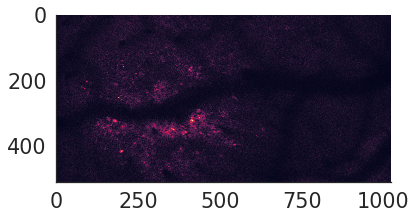

In [7]:
## I don't know if this is worth doing in python at all 
# Currently a placeholder
tiff_path = os.path.expanduser('~/mnt/qnap/Data/2021-03-10/STA/2021-03-10_RL116_t-001/'
                   '2021-03-10_RL116_t-001_15Stims_STA_dF_MaxResponseImage.tif')

image = tifffile.imread(tiff_path)
# Select the central 512 lines
image = image[int(512 - (1024 / 4)):int(512 + (1024 / 4)), :]
plt.imshow(image)

## Panel d

In [8]:
msm = MultiSessionModel(remove_targets=False, subsample_sessions=False,
                         remove_toosoon = True)

long post time
long post time
long post time
long post time
long post time
long post time
long post time
ALERT SESSIONS NOT SUBSAMPLED
long post time
long post time
long post time
long post time
long post time
long post time
long post time


In [60]:
print(msm.plot_string('Both', is_plot=False))

Hello Adam
Remove targets is False.
Remove too soon is True
Here are the sessions in play:
['Mouse J064, run 10', 'Mouse J064, run 11', 'Mouse J064, run 14', 'Mouse RL070, run 28', 'Mouse RL070, run 29', 'Mouse J063, run 9', 'Mouse J065, run 11']
Cells in region Both are includedpre-frames spans -1.97 to -0.07 inclusive
post-frames spans 0.83 to  8.0 inclusive


In [9]:
lm = msm.linear_models[0]
print(lm.session)

Mouse J064, run 10


In [10]:
def baseline_subtraction(flu, lm):
    
    ''' Takes a cell averaged flu matrix [n_trials x time]
        and subtracts pre-stim activity of an individual trial 
        from every timepoint in that trial.
        '''
    baseline = np.mean(flu[:, lm.frames_map['pre']], 1)
    flu = np.subtract(flu.T, baseline).T
    return flu

In [11]:
def nan_artifact(arr, lm):
    arr[~lm.remove_artifact] = np.nan
    return arr

In [12]:
def get_plot_trace(lm, targets=False, region='s1'):
    
    if targets:
        mask = ~lm.session.is_target
    else:
        mask = lm.session.is_target
    
    flu = lm.flu[lm.region_map[region], :, :]
    mask = mask[lm.region_map[region], :, :]
    
    # Fluoresence averaged across cells with (non)targets filtered
    flu = np.ma.array(flu, mask=mask).mean(0)
    
    flu = baseline_subtraction(flu, lm)
    
    global mean_trace
    
    x_axis = (np.arange(flu.shape[1]) - max(np.where(lm.pre)[0])) / 30
    print(x_axis.shape)
    x_axis = nan_artifact(x_axis, lm)
    mean_trace = nan_artifact(np.mean(flu, 0), lm)
    sem_trace = nan_artifact(np.std(flu, 0), lm) / flu.shape[0]
    
    plt.plot(x_axis, mean_trace)
    
    

(480,)
(480,)
(480,)


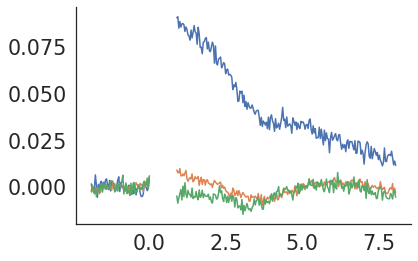

In [13]:
get_plot_trace(lm, targets=True, region='s1')
get_plot_trace(lm, targets=False, region='s1')
get_plot_trace(lm, targets=False, region='s2')

save_figure('Figure1PanelD', figure_path)

## Panels E and F are from fens poster

## Panel G

In [15]:
def get_subset_dprime(session):
    
    assert session.trial_subsets.shape == session.outcome.shape
    
    fp_rate = sum(session.outcome=='fp') / (sum(session.outcome=='fp') + sum(session.outcome=='cr'))
    subset_dprimes = []
    for subset in [[5, 10], [20, 30], [40, 50], [150]]:
        idx = np.isin(session.trial_subsets, subset)
        outcome = session.outcome[idx]
        hit_rate = sum(outcome=='hit') / (sum(outcome=='hit') + sum(outcome=='miss'))
        subset_dprimes.append(d_prime(hit_rate, fp_rate))
    
    return subset_dprimes

In [16]:
subset_dprimes = [get_subset_dprime(lm.session) for lm in msm.linear_models]
subset_dprimes = np.array(subset_dprimes)

In [17]:
# psychometric function
def pf(x, alpha, beta):
    return 1. / (1 + np.exp( -(x-alpha)/beta ))

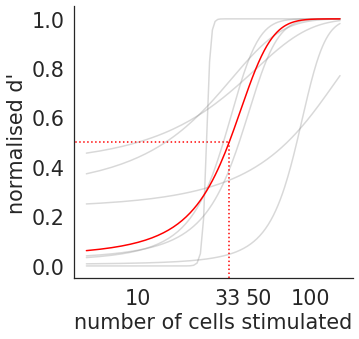

In [105]:
np.seterr(divide='ignore')  # Ugly division by 0 error
plt.figure(figsize=(5,5))

x_axis = [7.5, 25, 45, 150]
all_dp = []
for dp in subset_dprimes:
    dp = dp / max(dp)
    all_dp.append(dp)
    popt, pcov = curve_fit(pf, x_axis, dp, method='dogbox', p0=[50, 200])
    plt.plot(np.arange(5,max(x_axis)), pf(np.arange(5,max(x_axis)), *popt), color='grey', alpha=0.3)

    plt.xscale('log')
    
y = np.concatenate(all_dp)
x = np.tile(x_axis, subset_dprimes.shape[0])
popt, pcov = curve_fit(pf, x, y, method='dogbox', p0=[50, 200])
plt.plot(np.arange(5,max(x_axis)), pf(np.arange(5,max(x_axis)), *popt), color='red')

plt.xscale('log')
plt.ylabel('normalised d\'')
plt.xlabel('number of cells stimulated')
ticks = [10, int(popt[0]), 50, 100]
plt.axvline(x=popt[0], ymax=0.5, color='red', ls=':')
plt.hlines(y=0.5, xmin=0, xmax=popt[0], color='red', ls=':')

_ = plt.xticks(ticks, ticks)
save_figure('Figure1PanelG', figure_path)